In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.cluster import KMeans
import transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from torch import cuda
from sklearn.utils import class_weight
import seaborn as sns
from sklearn.decomposition import PCA
import random

In [2]:
# Defining some key variables that will be used later
MAX_LEN = 100
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 3e-5
MODEL_NAME = "bert-base-uncased"
NUM_CLUSTERS = 6

In [3]:
# Defining seeds for all random behavior
SEED = 30
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [4]:
# Preparing and returning data in a format that can be directly used for training the model
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text_description = dataframe.TextDescription
        self.truth_labels = dataframe.EncodedSeverity
        self.max_len = max_len

    def __len__(self):
        return len(self.text_description)

    def __getitem__(self, index):
        text_description = str(self.text_description[index])
        text_description = " ".join(text_description.split())

        inputs = self.tokenizer.encode_plus(
            text_description,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_token_type_ids=True
        )
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'truth_labels': torch.tensor(self.truth_labels[index], dtype=torch.long)
        }

In [5]:
# Creating the customized model, by adding a drop out and a linear layer on top of BERT to get the final output for the model. 
class BERTClass(torch.nn.Module):

    def __init__(self):
        super(BERTClass, self).__init__()
        self.pretrainedLayer = transformers.BertModel.from_pretrained(MODEL_NAME)
        self.dropOutLayer = torch.nn.Dropout(0.3)
        self.linearLayer = torch.nn.Linear(768, NUM_CLUSTERS)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        _, output_1= self.pretrainedLayer(input_ids, attention_mask = attention_mask, token_type_ids = token_type_ids, return_dict=False)
        output_2 = self.dropOutLayer(output_1)
        output = self.linearLayer(output_2)

        return output

In [6]:
# Setting up the device for GPU usage
device = 'cuda' if cuda.is_available() else 'cpu'

In [7]:
# Initializes the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BERTClass()
model.to(device)

BERTClass(
  (pretrainedLayer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

In [8]:
# Reading, preparing, and splitting the dataset into a testing and training set
df = pd.read_csv('../DataSet/CleanDataSet.csv')

train_size = 0.7
train_dataset=df.sample(frac=train_size,random_state=200)
test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)


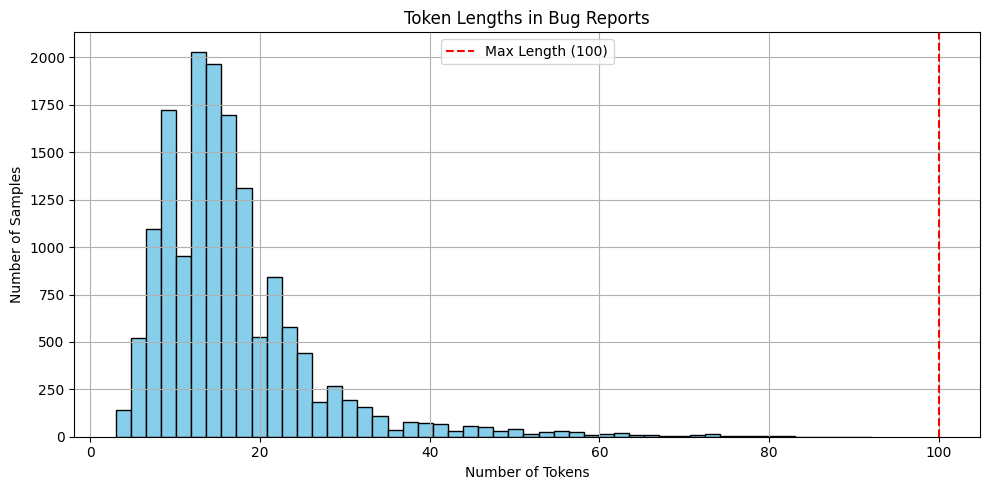

Average token length: 16.74
Median token length: 15.0
Max token length: 92
Percentage of samples >100 tokens: 0.00%


In [9]:
import matplotlib.pyplot as plt

# Encode all descriptions and store lengths
token_lengths = [len(tokenizer.encode(str(text), truncation=False)) for text in df['TextDescription']]

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(token_lengths, bins=50, color='skyblue', edgecolor='black')
plt.axvline(x=100, color='red', linestyle='--', label='Max Length (100)')
plt.title("Token Lengths in Bug Reports")
plt.xlabel("Number of Tokens")
plt.ylabel("Number of Samples")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print some stats
token_lengths = np.array(token_lengths)
print(f"Average token length: {np.mean(token_lengths):.2f}")
print(f"Median token length: {np.median(token_lengths)}")
print(f"Max token length: {np.max(token_lengths)}")
print(f"Percentage of samples >100 tokens: {(np.sum(token_lengths > 100) / len(token_lengths)) * 100:.2f}%")

In [10]:
# Setting up the DataLoader objects for training and testing datasets, specifying how the data should be loaded during training
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [11]:
# Adapting weights to balance an unbalanced dataset 
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=
                                                 np.unique(df.EncodedSeverity),
                                                 y=df.EncodedSeverity)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

def loss_fn(outputs, truth_labels):
    return torch.nn.CrossEntropyLoss(class_weights)(outputs, truth_labels)

In [12]:
# Using Adam Optimizer to optimize the loss
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
# Method for training the model
loss_list=[]
def train(epoch):
    epoch_loss = 0
    model.train()
    for data in training_loader:
        input_ids = data['input_ids'].to(device, dtype = torch.long)
        attention_mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        truth_labels = data['truth_labels'].to(device, dtype = torch.long)
        outputs = model(input_ids, attention_mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, truth_labels)
        
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()
        
        del input_ids, attention_mask, token_type_ids, outputs
        torch.cuda.empty_cache()
    avg_epoch_loss = epoch_loss / len(training_loader)
    print(f'Epoch: {epoch}, Loss:  {avg_epoch_loss}')
    loss_list.append(avg_epoch_loss)


In [ ]:
# Method for validating the training
def validation(epoch):
    model.eval()
    fin_truth_labels=[]
    fin_outputs=[]
    with torch.no_grad():
        for data in testing_loader:
            input_ids = data['input_ids'].to(device, dtype = torch.long)
            attention_mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            truth_labels = data['truth_labels'].to(device, dtype = torch.long)
            outputs = model(input_ids, attention_mask, token_type_ids)
            fin_outputs.extend(torch.argmax(outputs, dim=1).cpu().detach().numpy().tolist())
            fin_truth_labels.extend(truth_labels.cpu().detach().numpy().tolist())

    return fin_outputs, fin_truth_labels

In [15]:
# Train and validate the model
accuracy_list=[]
for epoch in range(EPOCHS):
    train(epoch)
    outputs, truth_labels = validation(epoch)
    outputs = np.array(outputs)
    accuracy = metrics.accuracy_score(truth_labels, outputs)
    accuracy_list.append(accuracy)
    print(f"Accuracy Score {epoch} = {accuracy}")

Epoch: 0, Loss:  1.7373504214187758
Accuracy Score 0 = 0.4487012987012987
Epoch: 1, Loss:  1.6290819499895905
Accuracy Score 1 = 0.4316017316017316
Epoch: 2, Loss:  1.4120059215438825
Accuracy Score 2 = 0.5051948051948052
Epoch: 3, Loss:  1.0987177575421616
Accuracy Score 3 = 0.45800865800865803
Epoch: 4, Loss:  0.746670772617224
Accuracy Score 4 = 0.5173160173160173


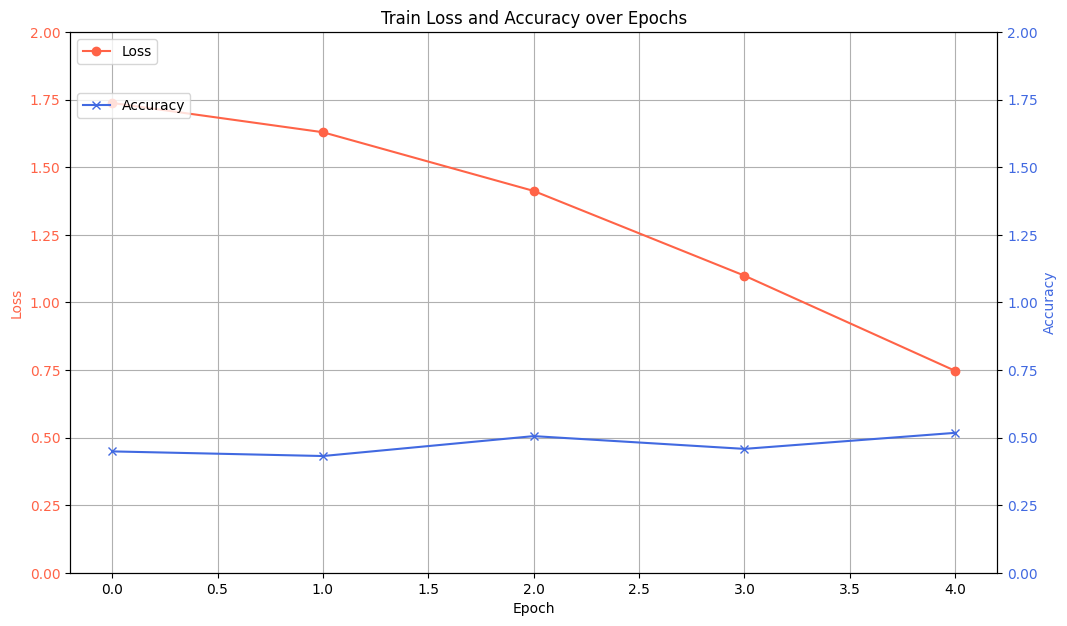

In [16]:
#  Plot both loss and accuracy on the same graph
fig, ax1 = plt.subplots(figsize=(10, 6))

fig.tight_layout()

# Plot training loss
ax1.plot(range(EPOCHS), loss_list, marker='o', linestyle='-', color='tomato', label='Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tomato')
ax1.tick_params(axis='y', labelcolor='tomato')
ax1.set_title('Train Loss and Accuracy over Epochs')
ax1.grid(True)

# Create a second y-axis for validation accuracy
ax2 = ax1.twinx()
ax2.plot(range(EPOCHS), accuracy_list, marker='x', linestyle='-', color='royalblue', label='Accuracy')
ax2.set_ylabel('Accuracy', color='royalblue')
ax2.tick_params(axis='y', labelcolor='royalblue')

ax1.set_ylim(0, 2)
ax2.set_ylim(0, 2)

ax1.legend(loc='upper left', bbox_to_anchor=(0, 1))
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.9))

In [17]:
# Method for getting embeddings and their respective truth label
def get_fine_tuned_embeddings(data_loader):
    model.eval()
    all_truth_labels = []
    embeddings_list = []

    with torch.no_grad():
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            
            # Extracting truth labels and converting to a 1d list
            labels = data['truth_labels'].cpu().numpy()
            for label in labels:
                all_truth_labels.append(int(label))

            # Get embeddings from the fine-tuned model
            outputs = model.pretrainedLayer(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, return_dict=True)
            embeddings = outputs['pooler_output'] 
            embeddings_list.append(embeddings.cpu().numpy())
                
    # Concatenate all embeddings into a single numpy array
    all_embeddings = np.vstack(embeddings_list)
    return all_embeddings, all_truth_labels

In [18]:
# Getting embeddings and their truth labels
embeddings_test, all_truth_labels = get_fine_tuned_embeddings(testing_loader)

In [19]:
embeddings = embeddings_test
original_indices = np.arange(len(embeddings))
print(embeddings.shape)

(4620, 768)


In [20]:
# Executing and evaluating Kmeans
cluster_labels = KMeans(
        n_clusters=NUM_CLUSTERS,
        max_iter=100,
        init='k-means++',
        n_init="auto",
        random_state=SEED,
    ).fit_predict(embeddings)
cluster_ids, cluster_sizes = np.unique(cluster_labels, return_counts=True)

print(f"Number of elements assigned to each cluster: {cluster_sizes}")

nmi = metrics.normalized_mutual_info_score(all_truth_labels, cluster_labels, average_method='geometric')
print("NMI: ", nmi)
ari = metrics.adjusted_rand_score(all_truth_labels, cluster_labels)
print("ARI: ", ari)

Number of elements assigned to each cluster: [ 994  636 1100  918  381  591]
NMI:  0.050610989496030094
ARI:  0.01173239857855665


<Axes: xlabel='PCA1', ylabel='PCA2'>

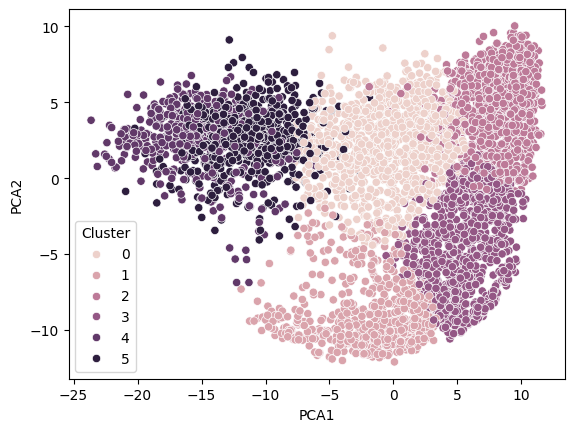

In [21]:
# Visualizing the clusters with a scatterplot
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

df_visual = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
df_visual['Cluster'] = cluster_labels

sns.scatterplot(x="PCA1", y="PCA2", data=df_visual, hue="Cluster")

<Axes: xlabel='Cluster', ylabel='0'>

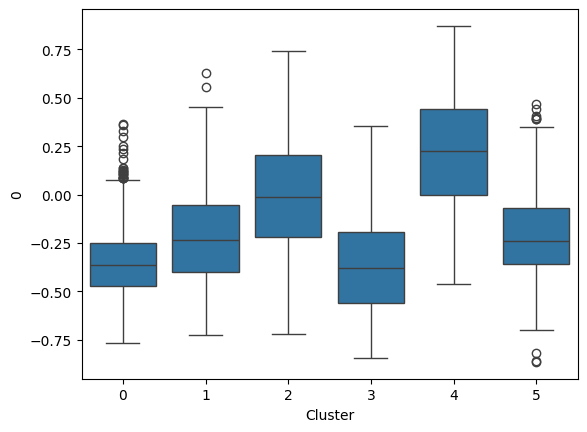

In [22]:
# Visualizing the clusters with a boxplot
df_box = pd.DataFrame(embeddings) 
df_box['Cluster'] = cluster_labels 
 
# Create a boxplot for the first embedding dimension 
sns.boxplot(x='Cluster', y=0, data=df_box)  # 0 is the index of the first embedding dimension